In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.style.use('ggplot')

# Loan Approval Competition

This notebook is intended to get to know the data for the Loan Approval Competition on 
kaggle. The model I am aiming to develop will predict whether a loan will be approved or not.

In [89]:
# load training data
train = pd.read_csv('data/train.csv')
train = train.set_index("id")
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [90]:
# shape of the data
print(f"Number of rows: {train.shape[0]}")
print(f"Number of columns: {train.shape[1]}")

Number of rows: 58645
Number of columns: 12


In [91]:
# look at data types
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


This dataset has 13 columns, including the id column and the target column. The dataset has 58645 rows, in the training set. The data involves some personal information
pertaining to the persons economic stance and some information on what type of loan 
they would want.

It is important to recognize that this model, in production could be used to determine 
someone's future and our model needs to be both accurate for the bank and fair for the 
customer, avoiding some bias towards certain groups of people.

## Loan Acceptance Analysis By Column

### Some Helper functions

To avoid code duplication below are some helper function for plotting and basic aggregations.

In [92]:
def plot_continuous(df: pd.DataFrame, column: str) -> None:
    """This is a function that plots two histograms showing difference
    in distributions between two output classes corresponding to variable in 
    question.
    
    Arguments:
        df: DataFrame = the dataset in question
        column: str = a continuous column from dataset
    """
    
    # first validate argument
    if column not in df.columns:
        raise ValueError(f"{column} is not in the DataFrame.")
    
    # create aggregations
    approved = df.query("loan_status == 0")[column]
    not_approved = df.query("loan_status == 1")[column]
    
    # create plot
    fig, (ax1, ax2) = plt.subplots(
        nrows=1, ncols=2, 
        sharex="all", sharey="all", 
        figsize=(10, 5)
    )
    ax1.hist(approved, label="Approved", color="dodgerblue", bins=20)
    ax1.set_ylabel("proportion")
    ax2.hist(not_approved, label="Not Approved", bins=20)
    fig.suptitle(f"Distribution of {column}")
    fig.legend()
    plt.show()
    
    
# plot_continuous(train, "loan_percent_income")

In [93]:
def plot_categorical(df: pd.DataFrame, column: str) -> None:
    """This is a function that plots two count plots showing difference
    in distributions between two output classes corresponding to variable in 
    question.
    
    Arguments:
        df: DataFrame = the dataset in question
        column: str = a continuous column from dataset
    """
    
    # first validate argument
    if column not in df.columns:
        raise ValueError(f"{column} is not in the DataFrame.")
    
    # create aggregations
    approved = df.query("loan_status == 0")[column].value_counts()
    not_approved = df.query("loan_status == 1")[column].value_counts()
    
    # create plot
    fig, (ax1, ax2) = plt.subplots(
        nrows=1, ncols=2, 
        sharex="all", sharey="all", 
        figsize=(10, 5)
    )
    ax1.bar(approved.index, approved.values, label="Approved", color="dodgerblue")
    ax2.bar(not_approved.index, not_approved.values, label="Not Approved")
    fig.suptitle(f"Distribution of {column}")
    fig.legend()
    plt.show()
    
    
# plot_categorical(train, "person_home_ownership")

### Loan Status

First things first, I want to ensure I understand what I am actually trying to predict.

In [94]:
# proportions of outcome classes
train["loan_status"].value_counts(normalize=True)

loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64

### Person Age

This could potentially be a column that can increase bias in the model. This could
be interesting to see if there is a real difference.

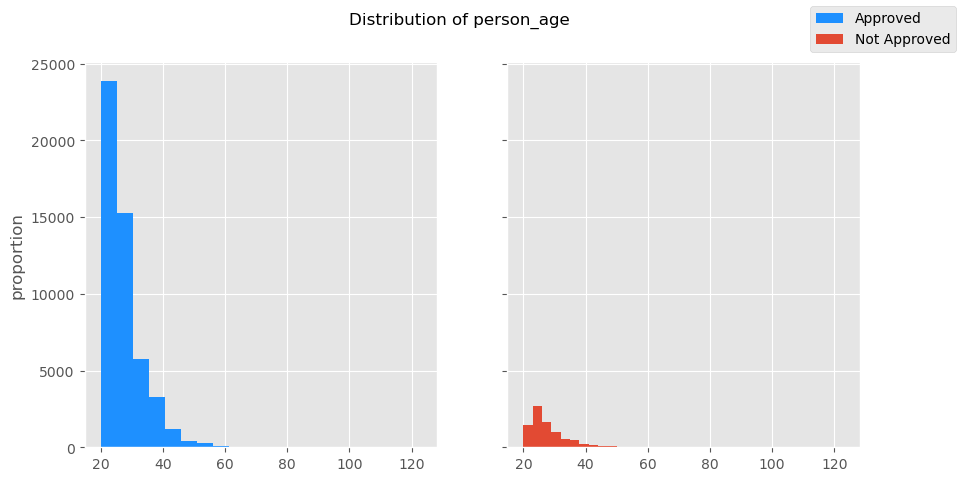

In [95]:
# start with plot to look for visual differences
plot_continuous(train, "person_age")

The two distributions of age look quite similar. This is interesting, I would expect the approved distribution to be slightly older than the group that was not approved.


In [96]:
approved = train.query("loan_status == 1")["person_age"]
not_approved = train.query("loan_status == 0")["person_age"]
p_val = stats.ttest_ind(approved, not_approved)[1].round(2)
print(f"p value is {p_val}")

p value is 0.78


With above results, there is not a significant different in the mean between the
two groups of data. The p value of 0.78 shows there is not enough evidence to show 
that these two samples come from different populations.

### Person Income

This should be a major factor in someone's ability to pay off a loan, but a proportion
of loan_amount / income could be a good metric as well.

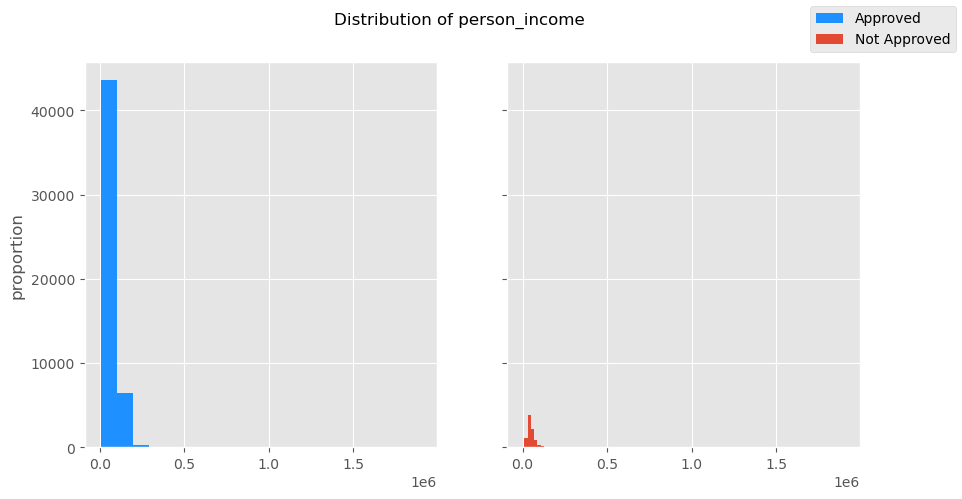

In [97]:
# plot income
plot_continuous(train, "person_income")

With such large differences in class label sizes, this plot does not provide much 
information.

In [98]:
train.groupby(["loan_status"])["person_income"].mean()

loan_status
0    66672.867720
1    48224.661796
Name: person_income, dtype: float64

This shows that people that get approved by loans tend to make more money, which 
makes sense and follows general intuition.

### Person Home Ownership

My general opinion is that someone who has ownership of their house would typically be 
in a better financial position and would be lower risk for default.

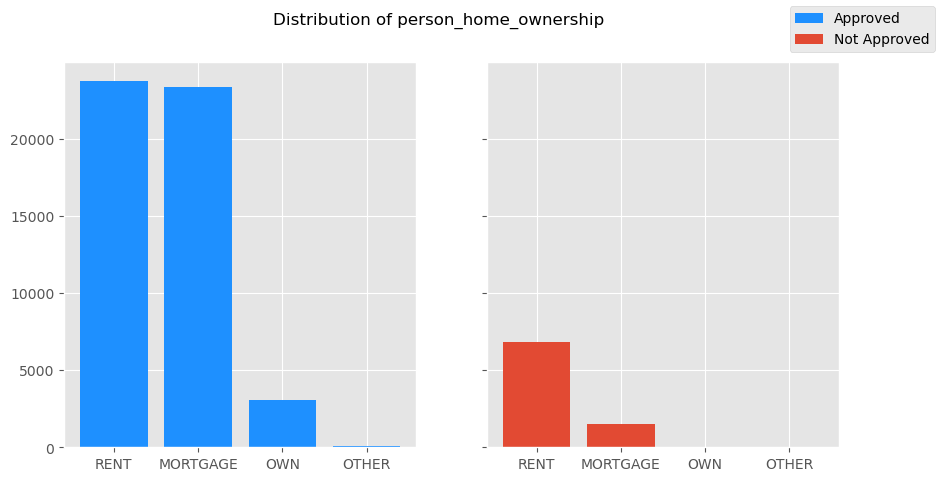

In [99]:
# plot differences
plot_categorical(train, "person_home_ownership")

In [103]:
# look at tabular representation
train.groupby(["person_home_ownership", "loan_status"])["loan_status"].count() /\
    train.groupby("loan_status")["loan_status"].count()

person_home_ownership  loan_status
MORTGAGE               0              0.464082
                       1              0.177605
OTHER                  0              0.001471
                       1              0.001796
OWN                    0              0.061537
                       1              0.005150
RENT                   0              0.472910
                       1              0.815449
Name: loan_status, dtype: float64

My previous claims seem to have merit, the people who tend to get rejected most often 
are mostly renters with about 80 % of them renting compared to around 47 % renters in 
other group. 

### Person Employment Length

This should have a large impact on someone's ability to pay a loan and is usually 
heavily correlated with a good credit rating.

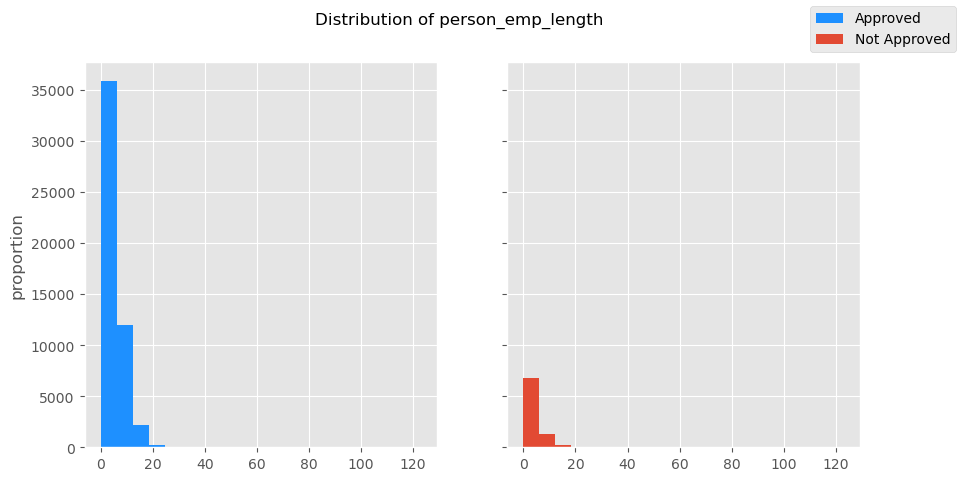

In [104]:
# plot
plot_continuous(train, "person_emp_length")